# 🎮 Jogo da Velha com Aprendizado por Reforço

## Descrição
Este notebook implementa um sistema de Jogo da Velha onde diferentes agentes competem e aprendem através de Q-Learning.

### Tipos de Agentes:
1. **Random (Randômico)** - Faz jogadas completamente aleatórias
2. **Greedy** - Sempre escolhe a melhor jogada conhecida (exploitation puro)
3. **Epsilon-Greedy** - Explora com probabilidade ε, explora com (1-ε)

### Características:
- Grid NxN configurável (N ≥ 3)
- Agente 1 sempre começa as partidas
- Sistema de aprendizado por Q-Learning
- Gráficos de evolução e estatísticas finais

## 📚 Importações

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, List, Optional
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 🎲 Classe do Jogo

In [3]:
class TicTacToeGame:
    """Classe que gerencia o tabuleiro e regras do jogo"""
    
    def __init__(self, grid_size: int = 3):
        self.grid_size = grid_size
        self.board = np.zeros((grid_size, grid_size), dtype=int)
        self.current_player = 1  # 1 para X, 2 para O
        
    def reset(self):
        """Reinicia o tabuleiro"""
        self.board = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.current_player = 1
        
    def get_available_moves(self) -> List[Tuple[int, int]]:
        """Retorna lista de posições vazias"""
        return [(i, j) for i in range(self.grid_size) 
                for j in range(self.grid_size) if self.board[i, j] == 0]
    
    def make_move(self, position: Tuple[int, int]) -> bool:
        """Faz uma jogada na posição especificada"""
        i, j = position
        if self.board[i, j] == 0:
            self.board[i, j] = self.current_player
            return True
        return False
    
    def check_winner(self) -> Optional[int]:
        """
        Verifica se há um vencedor
        Retorna: 1 (jogador 1 venceu), 2 (jogador 2 venceu), 0 (empate), None (jogo continua)
        """
        # Verifica linhas
        for i in range(self.grid_size):
            if np.all(self.board[i, :] == 1):
                return 1
            if np.all(self.board[i, :] == 2):
                return 2
        
        # Verifica colunas
        for j in range(self.grid_size):
            if np.all(self.board[:, j] == 1):
                return 1
            if np.all(self.board[:, j] == 2):
                return 2
        
        # Verifica diagonal principal
        if np.all(np.diag(self.board) == 1):
            return 1
        if np.all(np.diag(self.board) == 2):
            return 2
        
        # Verifica diagonal secundária
        if np.all(np.diag(np.fliplr(self.board)) == 1):
            return 1
        if np.all(np.diag(np.fliplr(self.board)) == 2):
            return 2
        
        # Verifica empate (tabuleiro cheio)
        if len(self.get_available_moves()) == 0:
            return 0
        
        return None
    
    def switch_player(self):
        """Alterna entre jogadores"""
        self.current_player = 3 - self.current_player  # Alterna entre 1 e 2
    
    def get_board_state(self) -> str:
        """Retorna representação em string do estado do tabuleiro"""
        return str(self.board.flatten())
    
    def display_board(self):
        """Exibe o tabuleiro de forma visual"""
        symbols = {0: '.', 1: 'X', 2: 'O'}
        print("\n  ", end="")
        for j in range(self.grid_size):
            print(f" {j}", end="")
        print()
        for i in range(self.grid_size):
            print(f"{i}  ", end="")
            for j in range(self.grid_size):
                print(f" {symbols[self.board[i, j]]}", end="")
            print()
        print()

## 🤖 Classes dos Agentes

In [4]:
class Agent:
    """Classe base para agentes"""
    
    def __init__(self, player_id: int, grid_size: int):
        self.player_id = player_id
        self.grid_size = grid_size
        # Q-table: {estado: {(i,j): valor}}
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.learning_rate = 0.1
        self.discount_factor = 0.9
        self.history = []  # Histórico de (estado, ação) para update posterior
        
    def choose_action(self, game: TicTacToeGame) -> Tuple[int, int]:
        """Método a ser sobrescrito pelas subclasses"""
        raise NotImplementedError
    
    def update_q_values(self, reward: float):
        """Atualiza valores Q baseado na recompensa final"""
        # Backward update: da última jogada para a primeira
        for idx in range(len(self.history) - 1, -1, -1):
            state, action = self.history[idx]
            
            # Q-Learning update simplificado
            current_q = self.q_table[state][action]
            
            # Para última jogada, usa recompensa direta
            # Para jogadas anteriores, propaga o valor com desconto
            if idx == len(self.history) - 1:
                new_q = current_q + self.learning_rate * (reward - current_q)
            else:
                next_state, next_action = self.history[idx + 1]
                next_q = self.q_table[next_state][next_action]
                new_q = current_q + self.learning_rate * (
                    self.discount_factor * next_q - current_q
                )
            
            self.q_table[state][action] = new_q
        
        # Limpa histórico para próxima partida
        self.history = []
    
    def record_move(self, state: str, action: Tuple[int, int]):
        """Registra uma jogada no histórico"""
        self.history.append((state, action))


class RandomAgent(Agent):
    """Agente que faz jogadas aleatórias"""
    
    def choose_action(self, game: TicTacToeGame) -> Tuple[int, int]:
        available_moves = game.get_available_moves()
        return random.choice(available_moves)


class GreedyAgent(Agent):
    """Agente que sempre escolhe a melhor jogada conhecida"""
    
    def choose_action(self, game: TicTacToeGame) -> Tuple[int, int]:
        available_moves = game.get_available_moves()
        state = game.get_board_state()
        
        # Se não tem conhecimento prévio, escolhe aleatoriamente
        if state not in self.q_table:
            return random.choice(available_moves)
        
        # Escolhe a ação com maior valor Q entre as disponíveis
        best_value = float('-inf')
        best_actions = []
        
        for action in available_moves:
            q_value = self.q_table[state][action]
            if q_value > best_value:
                best_value = q_value
                best_actions = [action]
            elif q_value == best_value:
                best_actions.append(action)
        
        return random.choice(best_actions)


class EpsilonGreedyAgent(Agent):
    """Agente que usa estratégia epsilon-greedy"""
    
    def __init__(self, player_id: int, grid_size: int, epsilon: float = 0.1):
        super().__init__(player_id, grid_size)
        self.epsilon = epsilon
    
    def choose_action(self, game: TicTacToeGame) -> Tuple[int, int]:
        available_moves = game.get_available_moves()
        state = game.get_board_state()
        
        # Exploração: escolhe ação aleatória com probabilidade epsilon
        if random.random() < self.epsilon:
            return random.choice(available_moves)
        
        # Exploitation: escolhe melhor ação conhecida
        if state not in self.q_table:
            return random.choice(available_moves)
        
        best_value = float('-inf')
        best_actions = []
        
        for action in available_moves:
            q_value = self.q_table[state][action]
            if q_value > best_value:
                best_value = q_value
                best_actions = [action]
            elif q_value == best_value:
                best_actions.append(action)
        
        return random.choice(best_actions)

## 🎯 Classe do Simulador

In [5]:
class GameSimulator:
    """Classe que simula partidas e coleta estatísticas"""
    
    def __init__(self, grid_size: int, agent1_type: str, agent2_type: str, 
                 epsilon1: float = 0.1, epsilon2: float = 0.1):
        self.grid_size = grid_size
        self.game = TicTacToeGame(grid_size)
        
        # Cria agentes baseado nos tipos especificados
        self.agent1 = self._create_agent(agent1_type, 1, epsilon1)
        self.agent2 = self._create_agent(agent2_type, 2, epsilon2)
        
        # Estatísticas
        self.stats = {
            'agent1_wins': 0,
            'agent2_wins': 0,
            'draws': 0,
            'agent1_wins_history': [],
            'agent2_wins_history': [],
            'draws_history': [],
            'agent1_win_rate': [],
            'agent2_win_rate': []
        }
        
    def _create_agent(self, agent_type: str, player_id: int, epsilon: float) -> Agent:
        """Cria agente do tipo especificado"""
        agent_type = agent_type.lower()
        if agent_type == 'random' or agent_type == 'randomico':
            return RandomAgent(player_id, self.grid_size)
        elif agent_type == 'greedy':
            return GreedyAgent(player_id, self.grid_size)
        elif agent_type == 'epsilon-greedy' or agent_type == 'e-greedy':
            return EpsilonGreedyAgent(player_id, self.grid_size, epsilon)
        else:
            raise ValueError(f"Tipo de agente inválido: {agent_type}")
    
    def play_game(self, verbose: bool = False) -> int:
        """
        Joga uma partida completa
        Retorna: 1 (agente1 venceu), 2 (agente2 venceu), 0 (empate)
        """
        self.game.reset()
        
        # Agente 1 sempre começa
        agents = [self.agent1, self.agent2]
        current_agent_idx = 0
        
        while True:
            current_agent = agents[current_agent_idx]
            
            # Escolhe e faz jogada
            state = self.game.get_board_state()
            action = current_agent.choose_action(self.game)
            current_agent.record_move(state, action)
            self.game.make_move(action)
            
            if verbose:
                self.game.display_board()
            
            # Verifica fim de jogo
            winner = self.game.check_winner()
            if winner is not None:
                # Atualiza Q-values com recompensas
                if winner == 1:  # Agente 1 venceu
                    self.agent1.update_q_values(1.0)
                    self.agent2.update_q_values(-1.0)
                elif winner == 2:  # Agente 2 venceu
                    self.agent1.update_q_values(-1.0)
                    self.agent2.update_q_values(1.0)
                else:  # Empate
                    self.agent1.update_q_values(0.1)
                    self.agent2.update_q_values(0.1)
                
                return winner
            
            # Alterna jogador
            self.game.switch_player()
            current_agent_idx = 1 - current_agent_idx
    
    def run_simulation(self, num_games: int, window_size: int = 100):
        """Executa múltiplas partidas e coleta estatísticas"""
        print(f"\n{'='*60}")
        print(f"Iniciando simulação: {num_games} partidas")
        print(f"Grid: {self.grid_size}x{self.grid_size}")
        print(f"Agente 1 (X): {type(self.agent1).__name__}")
        print(f"Agente 2 (O): {type(self.agent2).__name__}")
        print(f"{'='*60}\n")
        
        for game_num in range(num_games):
            result = self.play_game(verbose=False)
            
            if result == 1:
                self.stats['agent1_wins'] += 1
            elif result == 2:
                self.stats['agent2_wins'] += 1
            else:
                self.stats['draws'] += 1
            
            # Calcula taxa de vitória em janela móvel
            if (game_num + 1) % window_size == 0:
                games_played = game_num + 1
                self.stats['agent1_wins_history'].append(self.stats['agent1_wins'])
                self.stats['agent2_wins_history'].append(self.stats['agent2_wins'])
                self.stats['draws_history'].append(self.stats['draws'])
                
                self.stats['agent1_win_rate'].append(
                    self.stats['agent1_wins'] / games_played * 100
                )
                self.stats['agent2_win_rate'].append(
                    self.stats['agent2_wins'] / games_played * 100
                )
                
            # Progresso
            if (game_num + 1) % (max(1, num_games // 10)) == 0:
                progress = (game_num + 1) / num_games * 100
                print(f"Progresso: {progress:.0f}% ({game_num + 1}/{num_games} partidas)")
        
        print("\n✓ Simulação concluída!\n")
    
    def display_statistics(self):
        """Exibe estatísticas finais"""
        total_games = (self.stats['agent1_wins'] + 
                      self.stats['agent2_wins'] + 
                      self.stats['draws'])
        
        print(f"\n{'='*60}")
        print(f"ESTATÍSTICAS FINAIS - {total_games} partidas")
        print(f"{'='*60}")
        print(f"\nAgente 1 ({type(self.agent1).__name__}):")
        print(f"  Vitórias: {self.stats['agent1_wins']} "
              f"({self.stats['agent1_wins']/total_games*100:.1f}%)")
        
        print(f"\nAgente 2 ({type(self.agent2).__name__}):")
        print(f"  Vitórias: {self.stats['agent2_wins']} "
              f"({self.stats['agent2_wins']/total_games*100:.1f}%)")
        
        print(f"\nEmpates: {self.stats['draws']} "
              f"({self.stats['draws']/total_games*100:.1f}%)")
        print(f"{'='*60}\n")
    
    def plot_results(self):
        """Gera gráficos de evolução"""
        if not self.stats['agent1_win_rate']:
            print("Não há dados suficientes para plotar gráficos")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Análise de Evolução do Aprendizado', fontsize=16, fontweight='bold')
        
        # Gráfico 1: Taxa de vitória acumulada
        ax1 = axes[0, 0]
        x_points = range(len(self.stats['agent1_win_rate']))
        ax1.plot(x_points, self.stats['agent1_win_rate'], 
                label=f'Agente 1 ({type(self.agent1).__name__})', 
                marker='o', linewidth=2)
        ax1.plot(x_points, self.stats['agent2_win_rate'], 
                label=f'Agente 2 ({type(self.agent2).__name__})', 
                marker='s', linewidth=2)
        ax1.set_xlabel('Janela de partidas (×100)')
        ax1.set_ylabel('Taxa de Vitória (%)')
        ax1.set_title('Evolução da Taxa de Vitória')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Vitórias acumuladas
        ax2 = axes[0, 1]
        ax2.plot(x_points, self.stats['agent1_wins_history'], 
                label='Agente 1', marker='o', linewidth=2)
        ax2.plot(x_points, self.stats['agent2_wins_history'], 
                label='Agente 2', marker='s', linewidth=2)
        ax2.plot(x_points, self.stats['draws_history'], 
                label='Empates', marker='^', linewidth=2)
        ax2.set_xlabel('Janela de partidas (×100)')
        ax2.set_ylabel('Número de Vitórias')
        ax2.set_title('Vitórias Acumuladas')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Gráfico 3: Distribuição final de resultados (Pizza)
        ax3 = axes[1, 0]
        labels = ['Agente 1', 'Agente 2', 'Empates']
        sizes = [self.stats['agent1_wins'], 
                self.stats['agent2_wins'], 
                self.stats['draws']]
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        explode = (0.1, 0.1, 0)
        
        ax3.pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90)
        ax3.set_title('Distribuição de Resultados')
        
        # Gráfico 4: Comparação final (Barras)
        ax4 = axes[1, 1]
        categories = ['Vitórias', 'Derrotas', 'Empates']
        agent1_data = [self.stats['agent1_wins'], 
                      self.stats['agent2_wins'], 
                      self.stats['draws']]
        agent2_data = [self.stats['agent2_wins'], 
                      self.stats['agent1_wins'], 
                      self.stats['draws']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, agent1_data, width, 
                       label=f'Agente 1', color='#ff9999')
        bars2 = ax4.bar(x + width/2, agent2_data, width, 
                       label=f'Agente 2', color='#66b3ff')
        
        ax4.set_xlabel('Categoria')
        ax4.set_ylabel('Quantidade')
        ax4.set_title('Comparação de Desempenho')
        ax4.set_xticks(x)
        ax4.set_xticklabels(categories)
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Adiciona valores nas barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
   #def plot_q_table_heatmap(self, agent_num: int = 2):        """        Visualiza a Q-table do agente como heatmaps                Parâmetros:        - agent_num: 1 ou 2 (qual agente analisar)        """        # Seleciona o agente        agent = self.agent1 if agent_num == 1 else self.agent2        agent_name = f"Agente {agent_num} ({type(agent).__name__})"                # Verifica se é agente que aprende        if isinstance(agent, RandomAgent):            print(f"\n⚠️  {agent_name} é RandomAgent e não possui Q-table para visualizar.")            return                if len(agent.q_table) == 0:            print(f"\n⚠️  {agent_name} ainda não aprendeu nada (Q-table vazia).")            return                print(f"\n📊 Gerando heatmaps da Q-table para {agent_name}...")        print(f"   Estados aprendidos: {len(agent.q_table)}\n")                # Calcula estatísticas da Q-table        q_stats = self._calculate_q_statistics(agent)                # Identifica estados interessantes        empty_state = str(np.zeros(self.grid_size * self.grid_size, dtype=int))        top_states = self._find_top_visited_states(agent, num_states=2)                # Cria figura com subplots        fig = plt.figure(figsize=(16, 12))        fig.suptitle(f'Análise da Q-Table - {agent_name}',                      fontsize=16, fontweight='bold', y=0.98)                # Grid 2x2 de subplots        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)                # 1. Q-values médios gerais        ax1 = fig.add_subplot(gs[0, 0])        self._plot_heatmap_context(ax1, agent, q_stats['average_q'],                                    f"Q-values Médios Gerais\n({len(agent.q_table)} estados)",                                   show_board=False)                # 2. Q-values no tabuleiro vazio (primeira jogada)        ax2 = fig.add_subplot(gs[0, 1])        if empty_state in agent.q_table:            empty_q = self._get_state_q_values(agent, empty_state)            visits = q_stats['state_visits'].get(empty_state, 0)            self._plot_heatmap_context(ax2, agent, empty_q,                                       f"Primeira Jogada (Tabuleiro Vazio)\n(visitado {visits}x)",                                       show_board=True, state_str=empty_state)        else:            ax2.text(0.5, 0.5, 'Tabuleiro vazio\\nnão encontrado\\nna Q-table',                    ha='center', va='center', fontsize=12)            ax2.set_title("Primeira Jogada (Tabuleiro Vazio)\n(não visitado)")            ax2.axis('off')                # 3 e 4. Top estados mais visitados        for idx, (state, visits) in enumerate(top_states):            row = 1            col = idx            ax = fig.add_subplot(gs[row, col])                        state_q = self._get_state_q_values(agent, state)            self._plot_heatmap_context(ax, agent, state_q,                                       f"Estado Mais Visitado #{idx+1}\n(visitado {visits}x)",                                       show_board=True, state_str=state)                # Adiciona legenda geral        fig.text(0.5, 0.02,                 '🟢 Verde: Q-values altos (boas jogadas)  |  🟡 Amarelo: Q-values médios  |  🔴 Vermelho: Q-values baixos (jogadas ruins)',                ha='center', fontsize=11, style='italic')                plt.show()                # Imprime estatísticas adicionais        self._print_q_statistics(agent, q_stats)        def _calculate_q_statistics(self, agent: Agent) -> dict:        """Calcula estatísticas da Q-table"""        # Inicializa arrays para agregação        position_q_sums = np.zeros((self.grid_size, self.grid_size))        position_q_counts = np.zeros((self.grid_size, self.grid_size))        state_visits = defaultdict(int)                all_q_values = []                # Agrega Q-values por posição        for state, actions in agent.q_table.items():            state_visits[state] = len(actions)                        for action, q_value in actions.items():                i, j = action                position_q_sums[i, j] += q_value                position_q_counts[i, j] += 1                all_q_values.append(q_value)                # Calcula médias (evita divisão por zero)        average_q = np.divide(position_q_sums, position_q_counts,                              out=np.zeros_like(position_q_sums),                             where=position_q_counts > 0)                return {            'average_q': average_q,            'position_counts': position_q_counts,            'state_visits': state_visits,            'all_q_values': all_q_values,            'min_q': min(all_q_values) if all_q_values else 0,            'max_q': max(all_q_values) if all_q_values else 0,            'mean_q': np.mean(all_q_values) if all_q_values else 0        }        def _find_top_visited_states(self, agent: Agent, num_states: int = 2) -> list:        """Encontra os estados mais visitados"""        state_visit_counts = []                for state, actions in agent.q_table.items():            visit_count = len(actions)            state_visit_counts.append((state, visit_count))                # Ordena por número de visitas        state_visit_counts.sort(key=lambda x: x[1], reverse=True)                return state_visit_counts[:num_states]        def _get_state_q_values(self, agent: Agent, state_str: str) -> np.ndarray:        """Extrai Q-values de um estado específico como matriz"""        q_matrix = np.full((self.grid_size, self.grid_size), np.nan)                if state_str in agent.q_table:            for action, q_value in agent.q_table[state_str].items():                i, j = action                q_matrix[i, j] = q_value                return q_matrix        def _plot_heatmap_context(self, ax, agent: Agent, q_matrix: np.ndarray,                              title: str, show_board: bool = False,                              state_str: str = None):        """Plota um heatmap individual com contexto"""        # Se deve mostrar o tabuleiro, adiciona visualização do estado        if show_board and state_str:            # Converte string do estado para array            state_array = eval(state_str)            board = np.array(state_array).reshape(self.grid_size, self.grid_size)                        # Cria texto do tabuleiro            board_text = "Estado:\n"            symbols = {0: '.', 1: 'X', 2: 'O'}            for i in range(self.grid_size):                board_text += "  "                for j in range(self.grid_size):                    board_text += symbols[board[i, j]] + " "                board_text += "\n"                        # Adiciona ao título            title = board_text + "\n" + title                # Define range de cores baseado nos valores globais        vmin = np.nanmin(q_matrix) if not np.all(np.isnan(q_matrix)) else -1        vmax = np.nanmax(q_matrix) if not np.all(np.isnan(q_matrix)) else 1                # Cria máscara para células não visitadas        mask = np.isnan(q_matrix)                # Plota heatmap        sns.heatmap(q_matrix, annot=True, fmt='.2f', cmap='RdYlGn',                    center=0, vmin=vmin, vmax=vmax,                   cbar_kws={'label': 'Q-value'},                   linewidths=2, linecolor='black',                   mask=mask, ax=ax,                   annot_kws={'fontsize': 10, 'weight': 'bold'})                # Marca células não visitadas        for i in range(self.grid_size):            for j in range(self.grid_size):                if mask[i, j]:                    ax.text(j + 0.5, i + 0.5, '---',                           ha='center', va='center',                           fontsize=10, color='gray', style='italic')                ax.set_title(title, fontsize=11, fontweight='bold', pad=10)        ax.set_xlabel('')        ax.set_ylabel('')                # Labels dos eixos        ax.set_xticklabels(range(self.grid_size))        ax.set_yticklabels(range(self.grid_size))        def _print_q_statistics(self, agent: Agent, q_stats: dict):        """Imprime estatísticas detalhadas da Q-table"""        print(f"\n{'='*60}")        print(f"ESTATÍSTICAS DA Q-TABLE")        print(f"{'='*60}")                print(f"\nVisão Geral:")        print(f"  Estados únicos aprendidos: {len(agent.q_table)}")        print(f"  Total de pares (estado, ação): {int(q_stats['position_counts'].sum())}")                print(f"\nQ-Values:")        print(f"  Mínimo: {q_stats['min_q']:.3f}")        print(f"  Máximo: {q_stats['max_q']:.3f}")        print(f"  Média: {q_stats['mean_q']:.3f}")                print(f"\nPosições mais valorizadas (Q-value médio):")        avg_q = q_stats['average_q']        positions_with_q = []        for i in range(self.grid_size):            for j in range(self.grid_size):                if q_stats['position_counts'][i, j] > 0:                    positions_with_q.append(((i, j), avg_q[i, j],                                             int(q_stats['position_counts'][i, j])))                positions_with_q.sort(key=lambda x: x[1], reverse=True)                for idx, (pos, q_val, count) in enumerate(positions_with_q[:5]):            print(f"  {idx+1}. Posição {pos}: Q-avg = {q_val:.3f} (visitada {count}x)")                print(f"\n{'='*60}\n")

In [12]:
class GameSimulator:
    """Classe que simula partidas e coleta estatísticas"""
    
    def __init__(self, grid_size: int, agent1_type: str, agent2_type: str, 
                 epsilon1: float = 0.1, epsilon2: float = 0.1):
        self.grid_size = grid_size
        self.game = TicTacToeGame(grid_size)
        
        # Cria agentes baseado nos tipos especificados
        self.agent1 = self._create_agent(agent1_type, 1, epsilon1)
        self.agent2 = self._create_agent(agent2_type, 2, epsilon2)
        
        # Estatísticas
        self.stats = {
            'agent1_wins': 0,
            'agent2_wins': 0,
            'draws': 0,
            'agent1_wins_history': [],
            'agent2_wins_history': [],
            'draws_history': [],
            'agent1_win_rate': [],
            'agent2_win_rate': []
        }
        
    def _create_agent(self, agent_type: str, player_id: int, epsilon: float) -> Agent:
        """Cria agente do tipo especificado"""
        agent_type = agent_type.lower()
        if agent_type == 'random' or agent_type == 'randomico':
            return RandomAgent(player_id, self.grid_size)
        elif agent_type == 'greedy':
            return GreedyAgent(player_id, self.grid_size)
        elif agent_type == 'epsilon-greedy' or agent_type == 'e-greedy':
            return EpsilonGreedyAgent(player_id, self.grid_size, epsilon)
        else:
            raise ValueError(f"Tipo de agente inválido: {agent_type}")
    
    def play_game(self, verbose: bool = False) -> int:
        """
        Joga uma partida completa
        Retorna: 1 (agente1 venceu), 2 (agente2 venceu), 0 (empate)
        """
        self.game.reset()
        
        # Agente 1 sempre começa
        agents = [self.agent1, self.agent2]
        current_agent_idx = 0
        
        while True:
            current_agent = agents[current_agent_idx]
            
            # Escolhe e faz jogada
            state = self.game.get_board_state()
            action = current_agent.choose_action(self.game)
            current_agent.record_move(state, action)
            self.game.make_move(action)
            
            if verbose:
                self.game.display_board()
            
            # Verifica fim de jogo
            winner = self.game.check_winner()
            if winner is not None:
                # Atualiza Q-values com recompensas
                if winner == 1:  # Agente 1 venceu
                    self.agent1.update_q_values(1.0)
                    self.agent2.update_q_values(-1.0)
                elif winner == 2:  # Agente 2 venceu
                    self.agent1.update_q_values(-1.0)
                    self.agent2.update_q_values(1.0)
                else:  # Empate
                    self.agent1.update_q_values(0.1)
                    self.agent2.update_q_values(0.1)
                
                return winner
            
            # Alterna jogador
            self.game.switch_player()
            current_agent_idx = 1 - current_agent_idx
    
    def run_simulation(self, num_games: int, window_size: int = 100):
        """Executa múltiplas partidas e coleta estatísticas"""
        print(f"\n{'='*60}")
        print(f"Iniciando simulação: {num_games} partidas")
        print(f"Grid: {self.grid_size}x{self.grid_size}")
        print(f"Agente 1 (X): {type(self.agent1).__name__}")
        print(f"Agente 2 (O): {type(self.agent2).__name__}")
        print(f"{'='*60}\n")
        
        for game_num in range(num_games):
            result = self.play_game(verbose=False)
            
            if result == 1:
                self.stats['agent1_wins'] += 1
            elif result == 2:
                self.stats['agent2_wins'] += 1
            else:
                self.stats['draws'] += 1
            
            # Calcula taxa de vitória em janela móvel
            if (game_num + 1) % window_size == 0:
                games_played = game_num + 1
                self.stats['agent1_wins_history'].append(self.stats['agent1_wins'])
                self.stats['agent2_wins_history'].append(self.stats['agent2_wins'])
                self.stats['draws_history'].append(self.stats['draws'])
                
                self.stats['agent1_win_rate'].append(
                    self.stats['agent1_wins'] / games_played * 100
                )
                self.stats['agent2_win_rate'].append(
                    self.stats['agent2_wins'] / games_played * 100
                )
                
            # Progresso
            if (game_num + 1) % (max(1, num_games // 10)) == 0:
                progress = (game_num + 1) / num_games * 100
                print(f"Progresso: {progress:.0f}% ({game_num + 1}/{num_games} partidas)")
        
        print("\n✓ Simulação concluída!\n")
    
    def display_statistics(self):
        """Exibe estatísticas finais"""
        total_games = (self.stats['agent1_wins'] + 
                      self.stats['agent2_wins'] + 
                      self.stats['draws'])
        
        print(f"\n{'='*60}")
        print(f"ESTATÍSTICAS FINAIS - {total_games} partidas")
        print(f"{'='*60}")
        print(f"\nAgente 1 ({type(self.agent1).__name__}):")
        print(f"  Vitórias: {self.stats['agent1_wins']} "
              f"({self.stats['agent1_wins']/total_games*100:.1f}%)")
        
        print(f"\nAgente 2 ({type(self.agent2).__name__}):")
        print(f"  Vitórias: {self.stats['agent2_wins']} "
              f"({self.stats['agent2_wins']/total_games*100:.1f}%)")
        
        print(f"\nEmpates: {self.stats['draws']} "
              f"({self.stats['draws']/total_games*100:.1f}%)")
        print(f"{'='*60}\n")
    
    def plot_results(self):
        """Gera gráficos de evolução"""
        if not self.stats['agent1_win_rate']:
            print("Não há dados suficientes para plotar gráficos")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Análise de Evolução do Aprendizado', fontsize=16, fontweight='bold')
        
        # Gráfico 1: Taxa de vitória acumulada
        ax1 = axes[0, 0]
        x_points = range(len(self.stats['agent1_win_rate']))
        ax1.plot(x_points, self.stats['agent1_win_rate'], 
                label=f'Agente 1 ({type(self.agent1).__name__})', 
                marker='o', linewidth=2)
        ax1.plot(x_points, self.stats['agent2_win_rate'], 
                label=f'Agente 2 ({type(self.agent2).__name__})', 
                marker='s', linewidth=2)
        ax1.set_xlabel('Janela de partidas (×100)')
        ax1.set_ylabel('Taxa de Vitória (%)')
        ax1.set_title('Evolução da Taxa de Vitória')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Vitórias acumuladas
        ax2 = axes[0, 1]
        ax2.plot(x_points, self.stats['agent1_wins_history'], 
                label='Agente 1', marker='o', linewidth=2)
        ax2.plot(x_points, self.stats['agent2_wins_history'], 
                label='Agente 2', marker='s', linewidth=2)
        ax2.plot(x_points, self.stats['draws_history'], 
                label='Empates', marker='^', linewidth=2)
        ax2.set_xlabel('Janela de partidas (×100)')
        ax2.set_ylabel('Número de Vitórias')
        ax2.set_title('Vitórias Acumuladas')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Gráfico 3: Distribuição final de resultados (Pizza)
        ax3 = axes[1, 0]
        labels = ['Agente 1', 'Agente 2', 'Empates']
        sizes = [self.stats['agent1_wins'], 
                self.stats['agent2_wins'], 
                self.stats['draws']]
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        explode = (0.1, 0.1, 0)
        
        ax3.pie(sizes, explode=explode, labels=labels, colors=colors,
               autopct='%1.1f%%', shadow=True, startangle=90)
        ax3.set_title('Distribuição de Resultados')
        
        # Gráfico 4: Comparação final (Barras)
        ax4 = axes[1, 1]
        categories = ['Vitórias', 'Derrotas', 'Empates']
        agent1_data = [self.stats['agent1_wins'], 
                      self.stats['agent2_wins'], 
                      self.stats['draws']]
        agent2_data = [self.stats['agent2_wins'], 
                      self.stats['agent1_wins'], 
                      self.stats['draws']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, agent1_data, width, 
                       label=f'Agente 1', color='#ff9999')
        bars2 = ax4.bar(x + width/2, agent2_data, width, 
                       label=f'Agente 2', color='#66b3ff')
        
        ax4.set_xlabel('Categoria')
        ax4.set_ylabel('Quantidade')
        ax4.set_title('Comparação de Desempenho')
        ax4.set_xticks(x)
        ax4.set_xticklabels(categories)
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Adiciona valores nas barras
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def plot_q_table_heatmap(self, show_both: bool = False):
        """
        Visualiza a Q-table dos agentes como heatmaps
        
        Parâmetros:
        - show_both: Se True, mostra ambos os agentes lado a lado
        """
        # Determina quais agentes mostrar
        agents_to_show = []
        
        if show_both:
            if not isinstance(self.agent1, RandomAgent) and len(self.agent1.q_table) > 0:
                agents_to_show.append((1, self.agent1, 'Agente 1'))
            if not isinstance(self.agent2, RandomAgent) and len(self.agent2.q_table) > 0:
                agents_to_show.append((2, self.agent2, 'Agente 2'))
            
            if len(agents_to_show) == 0:
                print("\n⚠️  Nenhum agente com Q-table para visualizar.")
                return
            elif len(agents_to_show) == 1:
                print("\n⚠️  Apenas um agente tem Q-table. Mostrando apenas ele.")
                self._plot_single_agent_heatmap(agents_to_show[0][0])
                return
            
            # Mostra ambos lado a lado
            self._plot_both_agents_heatmap()
        else:
            # Mostra apenas agente 2 (comportamento padrão)
            self._plot_single_agent_heatmap(agent_num=2)
    
    def _plot_single_agent_heatmap(self, agent_num: int = 2):
        """Visualiza Q-table de um único agente"""
        # Seleciona o agente
        agent = self.agent1 if agent_num == 1 else self.agent2
        agent_name = f"Agente {agent_num} ({type(agent).__name__})"
        
        # Verifica se é agente que aprende
        if isinstance(agent, RandomAgent):
            print(f"\n⚠️  {agent_name} é RandomAgent e não possui Q-table para visualizar.")
            return
        
        if len(agent.q_table) == 0:
            print(f"\n⚠️  {agent_name} ainda não aprendeu nada (Q-table vazia).")
            return
        
        print(f"\n📊 Gerando heatmaps da Q-table para {agent_name}...")
        print(f"   Estados aprendidos: {len(agent.q_table)}\n")
        
        # Calcula estatísticas da Q-table
        q_stats = self._calculate_q_statistics(agent)
        
        # Identifica estados interessantes
        empty_state = str(np.zeros(self.grid_size * self.grid_size, dtype=int))
        top_states = self._find_top_visited_states(agent, num_states=2)
        
        # Cria figura com subplots
        fig = plt.figure(figsize=(16, 12))
        fig.suptitle(f'Análise da Q-Table - {agent_name}', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # Grid 2x2 de subplots
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
        
        # 1. Q-values médios gerais
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_heatmap_context(ax1, agent, q_stats['average_q'], 
                                   f"Q-values Médios Gerais\n({len(agent.q_table)} estados)",
                                   show_board=False)
        
        # 2. Q-values no tabuleiro vazio (primeira jogada)
        ax2 = fig.add_subplot(gs[0, 1])
        if empty_state in agent.q_table:
            empty_q = self._get_state_q_values(agent, empty_state)
            visits = q_stats['state_visits'].get(empty_state, 0)
            self._plot_heatmap_context(ax2, agent, empty_q,
                                       f"Primeira Jogada (Tabuleiro Vazio)\n(visitado {visits}x)",
                                       show_board=True, state_str=empty_state)
        else:
            ax2.text(0.5, 0.5, 'Tabuleiro vazio\nnão encontrado\nna Q-table',
                    ha='center', va='center', fontsize=12)
            ax2.set_title("Primeira Jogada (Tabuleiro Vazio)\n(não visitado)")
            ax2.axis('off')
        
        # 3 e 4. Top estados mais visitados
        for idx, (state, visits) in enumerate(top_states):
            row = 1
            col = idx
            ax = fig.add_subplot(gs[row, col])
            
            state_q = self._get_state_q_values(agent, state)
            self._plot_heatmap_context(ax, agent, state_q,
                                       f"Estado Mais Visitado #{idx+1}\n(visitado {visits}x)",
                                       show_board=True, state_str=state)
        
        # Adiciona legenda geral
        fig.text(0.5, 0.02, 
                '🟢 Verde: Q-values altos (boas jogadas)  |  🟡 Amarelo: Q-values médios  |  🔴 Vermelho: Q-values baixos (jogadas ruins)',
                ha='center', fontsize=11, style='italic')
        
        plt.show()
        
        # Imprime estatísticas adicionais
        self._print_q_statistics(agent, q_stats, agent_name)
    
    def _plot_both_agents_heatmap(self):
        """Visualiza Q-tables de ambos os agentes lado a lado"""
        print(f"\n📊 Gerando heatmaps comparativos para ambos os agentes...\n")
        
        # Calcula estatísticas para ambos
        q_stats1 = self._calculate_q_statistics(self.agent1)
        q_stats2 = self._calculate_q_statistics(self.agent2)
        
        # Cria figura com subplots 2x2
        fig = plt.figure(figsize=(18, 12))
        fig.suptitle('Comparação de Q-Tables - Ambos os Agentes', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # Grid 2x2 de subplots
        gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.25)
        
        # ===== AGENTE 1 =====
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_heatmap_context(ax1, self.agent1, q_stats1['average_q'],
                                   f"Agente 1 - Q-values Médios Gerais\n"
                                   f"{type(self.agent1).__name__} ({len(self.agent1.q_table)} estados)",
                                   show_board=False)
        
        # Primeira jogada Agente 1
        ax2 = fig.add_subplot(gs[1, 0])
        empty_state = str(np.zeros(self.grid_size * self.grid_size, dtype=int))
        if empty_state in self.agent1.q_table:
            empty_q1 = self._get_state_q_values(self.agent1, empty_state)
            visits1 = q_stats1['state_visits'].get(empty_state, 0)
            self._plot_heatmap_context(ax2, self.agent1, empty_q1,
                                       f"Agente 1 - Primeira Jogada\n(visitado {visits1}x)",
                                       show_board=True, state_str=empty_state)
        else:
            ax2.text(0.5, 0.5, 'Tabuleiro vazio\nnão encontrado',
                    ha='center', va='center', fontsize=11)
            ax2.set_title("Agente 1 - Primeira Jogada\n(não visitado)")
            ax2.axis('off')
        
        # ===== AGENTE 2 =====
        ax3 = fig.add_subplot(gs[0, 1])
        self._plot_heatmap_context(ax3, self.agent2, q_stats2['average_q'],
                                   f"Agente 2 - Q-values Médios Gerais\n"
                                   f"{type(self.agent2).__name__} ({len(self.agent2.q_table)} estados)",
                                   show_board=False)
        
        # Primeira jogada Agente 2
        ax4 = fig.add_subplot(gs[1, 1])
        if empty_state in self.agent2.q_table:
            empty_q2 = self._get_state_q_values(self.agent2, empty_state)
            visits2 = q_stats2['state_visits'].get(empty_state, 0)
            self._plot_heatmap_context(ax4, self.agent2, empty_q2,
                                       f"Agente 2 - Primeira Jogada\n(visitado {visits2}x)",
                                       show_board=True, state_str=empty_state)
        else:
            ax4.text(0.5, 0.5, 'Tabuleiro vazio\nnão encontrado',
                    ha='center', va='center', fontsize=11)
            ax4.set_title("Agente 2 - Primeira Jogada\n(não visitado)")
            ax4.axis('off')
        
        # Adiciona legenda geral
        fig.text(0.5, 0.02,
                '🟢 Verde: Q-values altos (boas jogadas)  |  🟡 Amarelo: Q-values médios  |  🔴 Vermelho: Q-values baixos (jogadas ruins)',
                ha='center', fontsize=11, style='italic')
        
        plt.show()
        
        # Imprime comparação de estatísticas
        print(f"\n{'='*70}")
        print(f"COMPARAÇÃO DE ESTATÍSTICAS")
        print(f"{'='*70}\n")
        
        print(f"{'Métrica':<30} {'Agente 1':<20} {'Agente 2':<20}")
        print(f"{'-'*70}")
        print(f"{'Tipo':<30} {type(self.agent1).__name__:<20} {type(self.agent2).__name__:<20}")
        print(f"{'Estados aprendidos':<30} {len(self.agent1.q_table):<20} {len(self.agent2.q_table):<20}")
        print(f"{'Q-value mínimo':<30} {q_stats1['min_q']:<20.3f} {q_stats2['min_q']:<20.3f}")
        print(f"{'Q-value máximo':<30} {q_stats1['max_q']:<20.3f} {q_stats2['max_q']:<20.3f}")
        print(f"{'Q-value médio':<30} {q_stats1['mean_q']:<20.3f} {q_stats2['mean_q']:<20.3f}")
        print(f"{'='*70}\n")
    
    def _calculate_q_statistics(self, agent: Agent) -> dict:
        """Calcula estatísticas da Q-table"""
        # Inicializa arrays para agregação
        position_q_sums = np.zeros((self.grid_size, self.grid_size))
        position_q_counts = np.zeros((self.grid_size, self.grid_size))
        state_visits = defaultdict(int)
        
        all_q_values = []
        
        # Agrega Q-values por posição
        for state, actions in agent.q_table.items():
            state_visits[state] = len(actions)
            
            for action, q_value in actions.items():
                i, j = action
                position_q_sums[i, j] += q_value
                position_q_counts[i, j] += 1
                all_q_values.append(q_value)
        
        # Calcula médias (evita divisão por zero)
        average_q = np.divide(position_q_sums, position_q_counts, 
                             out=np.zeros_like(position_q_sums),
                             where=position_q_counts > 0)
        
        return {
            'average_q': average_q,
            'position_counts': position_q_counts,
            'state_visits': state_visits,
            'all_q_values': all_q_values,
            'min_q': min(all_q_values) if all_q_values else 0,
            'max_q': max(all_q_values) if all_q_values else 0,
            'mean_q': np.mean(all_q_values) if all_q_values else 0
        }
    
    def _find_top_visited_states(self, agent: Agent, num_states: int = 2) -> list:
        """Encontra os estados mais visitados"""
        state_visit_counts = []
        
        for state, actions in agent.q_table.items():
            visit_count = len(actions)
            state_visit_counts.append((state, visit_count))
        
        # Ordena por número de visitas
        state_visit_counts.sort(key=lambda x: x[1], reverse=True)
        
        return state_visit_counts[:num_states]
    
    def _get_state_q_values(self, agent: Agent, state_str: str) -> np.ndarray:
        """Extrai Q-values de um estado específico como matriz"""
        q_matrix = np.full((self.grid_size, self.grid_size), np.nan)
        
        if state_str in agent.q_table:
            for action, q_value in agent.q_table[state_str].items():
                i, j = action
                q_matrix[i, j] = q_value
        
        return q_matrix
    
    def _plot_heatmap_context(self, ax, agent: Agent, q_matrix: np.ndarray, 
                             title: str, show_board: bool = False, 
                             state_str: str = None):
        """Plota um heatmap individual com contexto"""
        # Se deve mostrar o tabuleiro, adiciona visualização do estado
        if show_board and state_str:
            # Converte string do estado para array
            # Remove colchetes e converte para array
            state_str_clean = state_str.strip('[]')
            state_array = np.fromstring(state_str_clean, sep=' ', dtype=int)
            board = state_array.reshape(self.grid_size, self.grid_size)
            
            # Cria texto do tabuleiro
            board_text = "Estado:\n"
            symbols = {0: '.', 1: 'X', 2: 'O'}
            for i in range(self.grid_size):
                board_text += "  "
                for j in range(self.grid_size):
                    board_text += symbols[board[i, j]] + " "
                board_text += "\n"
            
            # Adiciona ao título
            title = board_text + "\n" + title
        
        # Define range de cores baseado nos valores globais
        vmin = np.nanmin(q_matrix) if not np.all(np.isnan(q_matrix)) else -1
        vmax = np.nanmax(q_matrix) if not np.all(np.isnan(q_matrix)) else 1
        
        # Cria máscara para células não visitadas
        mask = np.isnan(q_matrix)
        
        # Plota heatmap
        sns.heatmap(q_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
                   center=0, vmin=vmin, vmax=vmax,
                   cbar_kws={'label': 'Q-value'},
                   linewidths=2, linecolor='black',
                   mask=mask, ax=ax,
                   annot_kws={'fontsize': 10, 'weight': 'bold'})
        
        # Marca células não visitadas
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if mask[i, j]:
                    ax.text(j + 0.5, i + 0.5, '---',
                           ha='center', va='center',
                           fontsize=10, color='gray', style='italic')
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Labels dos eixos
        ax.set_xticklabels(range(self.grid_size))
        ax.set_yticklabels(range(self.grid_size))
    
    def _print_q_statistics(self, agent: Agent, q_stats: dict, agent_name: str):
        """Imprime estatísticas detalhadas da Q-table"""
        print(f"\n{'='*60}")
        print(f"ESTATÍSTICAS DA Q-TABLE - {agent_name}")
        print(f"{'='*60}")
        
        print(f"\nVisão Geral:")
        print(f"  Estados únicos aprendidos: {len(agent.q_table)}")
        print(f"  Total de pares (estado, ação): {int(q_stats['position_counts'].sum())}")
        
        print(f"\nQ-Values:")
        print(f"  Mínimo: {q_stats['min_q']:.3f}")
        print(f"  Máximo: {q_stats['max_q']:.3f}")
        print(f"  Média: {q_stats['mean_q']:.3f}")
        
        print(f"\nPosições mais valorizadas (Q-value médio):")
        avg_q = q_stats['average_q']
        positions_with_q = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if q_stats['position_counts'][i, j] > 0:
                    positions_with_q.append(((i, j), avg_q[i, j], 
                                            int(q_stats['position_counts'][i, j])))
        
        positions_with_q.sort(key=lambda x: x[1], reverse=True)
        
        for idx, (pos, q_val, count) in enumerate(positions_with_q[:5]):
            print(f"  {idx+1}. Posição {pos}: Q-avg = {q_val:.3f} (visitada {count}x)")
        
        print(f"\n{'='*60}\n")

## ⚙️ Configuração e Execução

Configure os parâmetros abaixo e execute a simulação!

In [45]:
# ========== CONFIGURAÇÕES ==========

# Tamanho do grid (N x N, onde N >= 3)
GRID_SIZE = 3

# Tipo dos agentes: 'random', 'greedy', 'epsilon-greedy'
AGENT1_TYPE = 'greedy'
AGENT2_TYPE = 'epsilon-greedy'

# Epsilon para agentes epsilon-greedy (0.0 a 1.0)
EPSILON1 = 0.1
EPSILON2 = 0.1

# Número de partidas a simular
NUM_GAMES = 10000

# ===================================

In [46]:
# Criar e executar simulação
simulator = GameSimulator(
    grid_size=GRID_SIZE,
    agent1_type=AGENT1_TYPE,
    agent2_type=AGENT2_TYPE,
    epsilon1=EPSILON1,
    epsilon2=EPSILON2
)

# Executar simulação
simulator.run_simulation(NUM_GAMES)


Iniciando simulação: 10000 partidas
Grid: 3x3
Agente 1 (X): GreedyAgent
Agente 2 (O): EpsilonGreedyAgent

Progresso: 10% (1000/10000 partidas)
Progresso: 20% (2000/10000 partidas)
Progresso: 30% (3000/10000 partidas)
Progresso: 40% (4000/10000 partidas)
Progresso: 50% (5000/10000 partidas)
Progresso: 60% (6000/10000 partidas)
Progresso: 70% (7000/10000 partidas)
Progresso: 80% (8000/10000 partidas)
Progresso: 90% (9000/10000 partidas)
Progresso: 100% (10000/10000 partidas)

✓ Simulação concluída!



In [42]:
# Exibir estatísticas finais
simulator.display_statistics()


ESTATÍSTICAS FINAIS - 10000 partidas

Agente 1 (GreedyAgent):
  Vitórias: 9180 (91.8%)

Agente 2 (RandomAgent):
  Vitórias: 179 (1.8%)

Empates: 641 (6.4%)



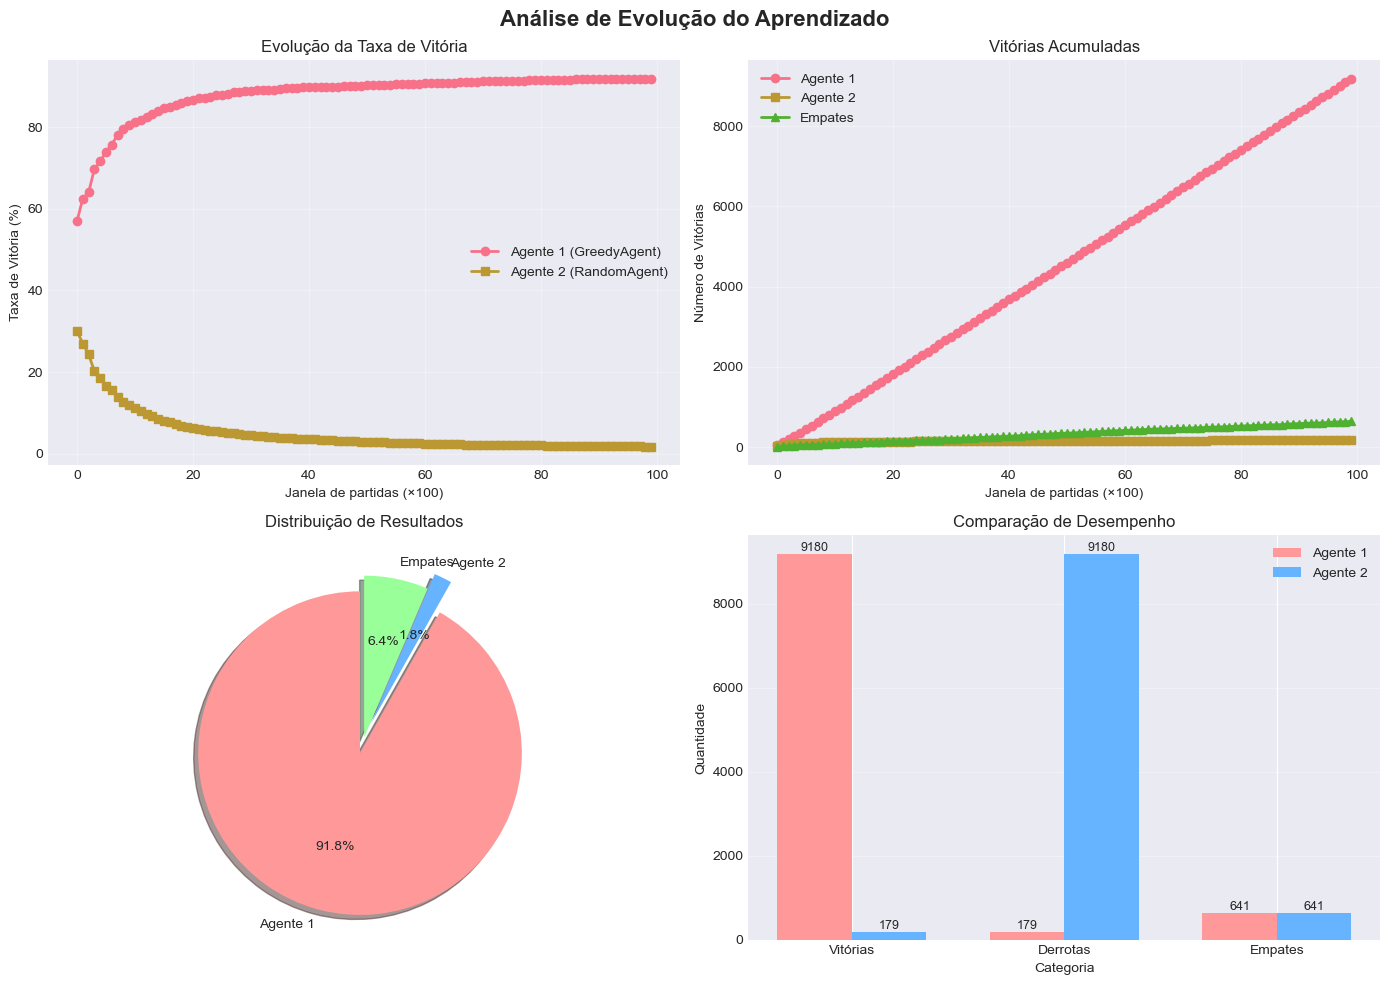

In [43]:
# Gerar gráficos de evolução
simulator.plot_results()

## 🎨 Visualização da Q-Table como Heatmap

Visualize os Q-values aprendidos pelo agente inteligente!


⚠️  Apenas um agente tem Q-table. Mostrando apenas ele.

📊 Gerando heatmaps da Q-table para Agente 1 (GreedyAgent)...
   Estados aprendidos: 344



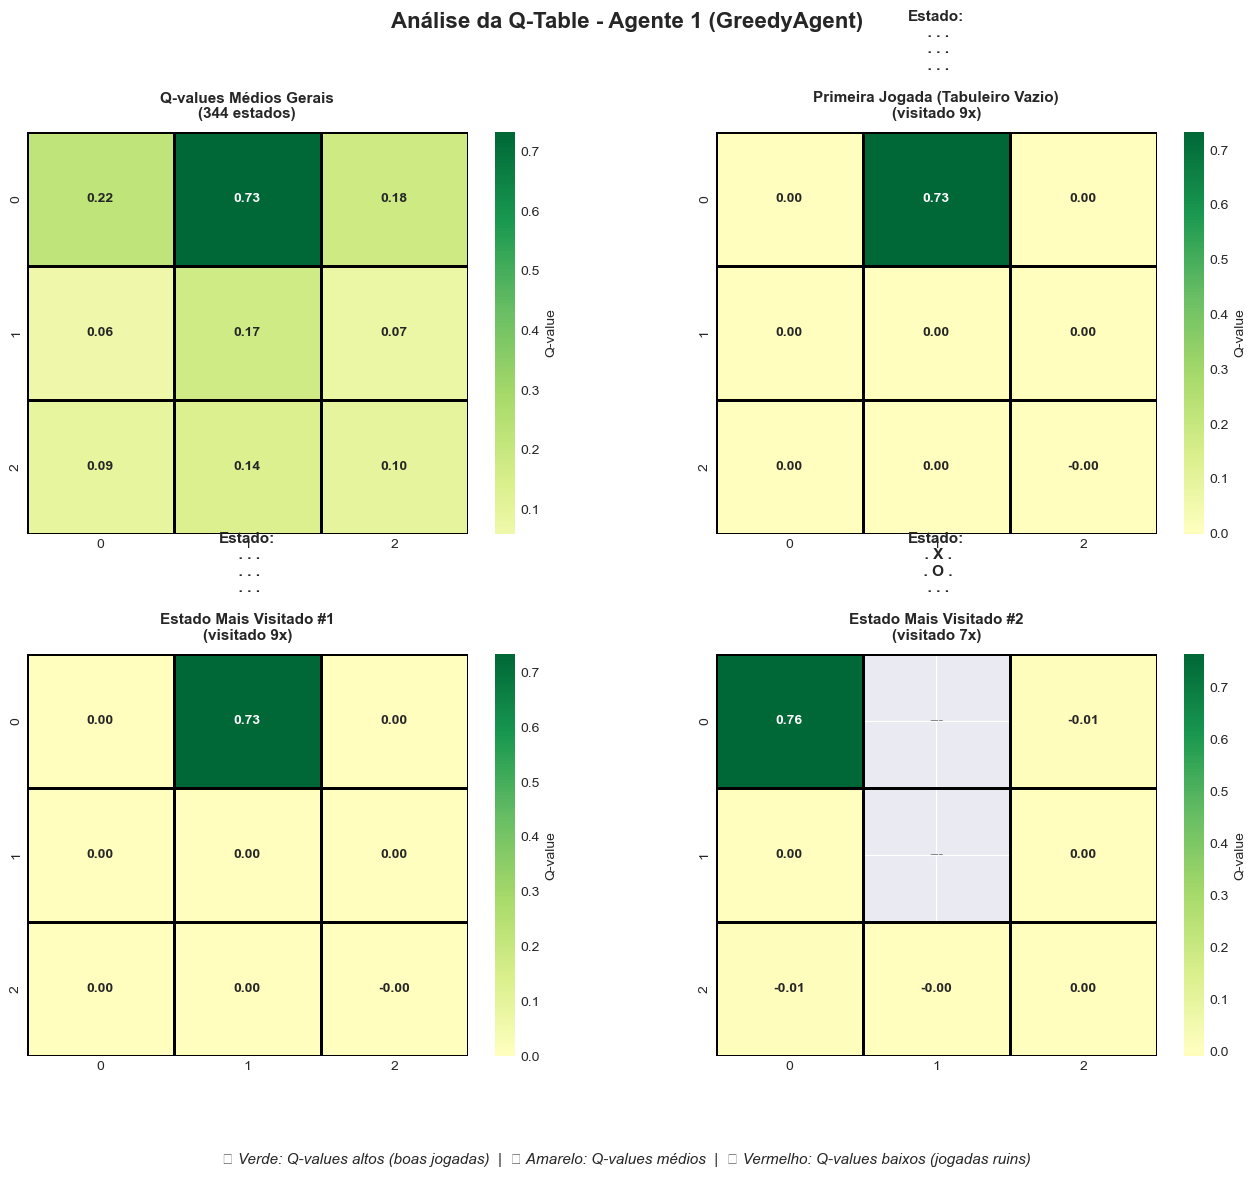


ESTATÍSTICAS DA Q-TABLE - Agente 1 (GreedyAgent)

Visão Geral:
  Estados únicos aprendidos: 344
  Total de pares (estado, ação): 880

Q-Values:
  Mínimo: -0.582
  Máximo: 1.000
  Média: 0.127

Posições mais valorizadas (Q-value médio):
  1. Posição (0, 1): Q-avg = 0.733 (visitada 1x)
  2. Posição (0, 0): Q-avg = 0.217 (visitada 101x)
  3. Posição (0, 2): Q-avg = 0.182 (visitada 87x)
  4. Posição (1, 1): Q-avg = 0.172 (visitada 112x)
  5. Posição (2, 1): Q-avg = 0.138 (visitada 119x)




In [44]:
# Visualizar Q-table do Agente 2 (se for agente que aprende)
simulator.plot_q_table_heatmap(show_both=True)

## 🎮 Testar uma Partida Individual

Execute para ver uma partida sendo jogada passo a passo:

In [ ]:
# Criar novo simulador para teste
test_sim = GameSimulator(
    grid_size=3,
    agent1_type='random',
    agent2_type='greedy',
    epsilon1=0.1,
    epsilon2=0.1
)

# Jogar uma partida com visualização
print("\n" + "="*40)
print("PARTIDA DE TESTE")
print("="*40)
winner = test_sim.play_game(verbose=True)

if winner == 1:
    print("\n🎉 Agente 1 (X) venceu!")
elif winner == 2:
    print("\n🎉 Agente 2 (O) venceu!")
else:
    print("\n🤝 Empate!")

## 📊 Experimentos Sugeridos

Teste diferentes combinações de agentes:

### Experimento 1: Random vs Random (Baseline)
```python
AGENT1_TYPE = 'random'
AGENT2_TYPE = 'random'
NUM_GAMES = 10000
```

### Experimento 2: Greedy vs Random
```python
AGENT1_TYPE = 'random'
AGENT2_TYPE = 'greedy'
NUM_GAMES = 10000
```

### Experimento 3: Epsilon-Greedy vs Random
```python
AGENT1_TYPE = 'random'
AGENT2_TYPE = 'epsilon-greedy'
EPSILON2 = 0.2  # Tente diferentes valores!
NUM_GAMES = 10000
```

### Experimento 4: Greedy vs Epsilon-Greedy
```python
AGENT1_TYPE = 'greedy'
AGENT2_TYPE = 'epsilon-greedy'
EPSILON2 = 0.15
NUM_GAMES = 10000
```

### Experimento 5: Grid Maior (5x5)
```python
GRID_SIZE = 5
AGENT1_TYPE = 'random'
AGENT2_TYPE = 'greedy'
NUM_GAMES = 5000  # Pode demorar mais!
```

## 🔍 Análise do Q-Table

Veja quais estados o agente aprendeu:

In [ ]:
# Quantidade de estados aprendidos por cada agente
print(f"\nAgente 1 - Estados aprendidos: {len(simulator.agent1.q_table)}")
print(f"Agente 2 - Estados aprendidos: {len(simulator.agent2.q_table)}")

# Ver alguns dos melhores valores Q do Agente 2
if len(simulator.agent2.q_table) > 0:
    print("\nTop 5 melhores valores Q do Agente 2:")
    all_q_values = []
    for state, actions in simulator.agent2.q_table.items():
        for action, q_val in actions.items():
            all_q_values.append((q_val, state, action))
    
    all_q_values.sort(reverse=True)
    for i, (q_val, state, action) in enumerate(all_q_values[:5]):
        print(f"{i+1}. Q-value: {q_val:.3f} | Ação: {action}")

## 🔬 Análise Avançada: Interpretando os Heatmaps

### Como Interpretar os Gráficos:

#### 1. **Q-values Médios Gerais**
- Mostra a média de Q-values para cada posição do tabuleiro
- **Verde**: Posições que geralmente levam a vitórias
- **Amarelo**: Posições neutras
- **Vermelho**: Posições que geralmente levam a derrotas
- **---**: Posição nunca foi visitada

#### 2. **Primeira Jogada (Tabuleiro Vazio)**
- Estratégia do agente para a primeira jogada
- Geralmente o **centro (1,1) em 3x3** tem Q-value alto
- Mostra quantas vezes o agente começou uma partida

#### 3 e 4. **Estados Mais Visitados**
- Situações que ocorreram com frequência durante o treinamento
- Mostra o tabuleiro atual e os Q-values para jogadas possíveis
- **---** indica posições já ocupadas (não disponíveis)

### Estatísticas Detalhadas:
- **Estados únicos**: Quantos estados diferentes o agente visitou
- **Q-value mínimo/máximo/médio**: Range de valores aprendidos
- **Posições mais valorizadas**: Top 5 melhores posições em média

## 💡 Exemplo Completo: Análise de Aprendizado

Execute este exemplo completo para ver todo o pipeline:

In [ ]:
# Exemplo completo de análise
print("="*60)
print("EXEMPLO COMPLETO: Random vs Greedy")
print("="*60)

# Configuração
example_sim = GameSimulator(
    grid_size=3,
    agent1_type='random',
    agent2_type='greedy',
    epsilon1=0.1,
    epsilon2=0.1
)

# Treinar
example_sim.run_simulation(10000)

# Estatísticas
example_sim.display_statistics()

# Gráficos de evolução
example_sim.plot_results()

# NOVO: Heatmap da Q-table
example_sim.plot_q_table_heatmap(agent_num=2)

## 🎯 Experimentos Comparativos de Q-Tables

Compare como diferentes configurações afetam o aprendizado:

In [ ]:
# Experimento: Comparar Greedy vs Epsilon-Greedy

print("\n" + "="*60)
print("EXPERIMENTO 1: Greedy Puro")
print("="*60)

sim_greedy = GameSimulator(grid_size=3, agent1_type='random', 
                           agent2_type='greedy')
sim_greedy.run_simulation(5000)
sim_greedy.plot_q_table_heatmap(agent_num=2)

print("\n" + "="*60)
print("EXPERIMENTO 2: Epsilon-Greedy (ε=0.15)")
print("="*60)

sim_egreedy = GameSimulator(grid_size=3, agent1_type='random',
                            agent2_type='epsilon-greedy', epsilon2=0.15)
sim_egreedy.run_simulation(5000)
sim_egreedy.plot_q_table_heatmap(agent_num=2)

# Observe as diferenças nos heatmaps!

## 📝 Exercício: Análise de Padrões

Após executar os experimentos acima, responda:

1. **Qual posição tem o maior Q-value médio?**
   - No grid 3x3, o centro (1,1) é geralmente a melhor?
   
2. **Compare Greedy vs Epsilon-Greedy:**
   - Qual tem mais estados aprendidos?
   - Qual tem Q-values mais altos?
   - Qual tem melhor distribuição de valores?

3. **Estados mais visitados:**
   - Esses estados fazem sentido estrategicamente?
   - Por que certos estados aparecem mais frequentemente?

4. **Primeira jogada:**
   - O agente aprendeu a jogar no centro?
   - Como isso afeta a taxa de vitória?